# Step 1: Minimal Octo Inference Example

This notebook demonstrates how to load a pre-trained / finetuned Octo checkpoint, run inference on some images, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Step 2: Run Inference on Full Trajectories

That was easy! Now let's try to run inference across a whole trajectory and visualize the results!

In [ ]:
# Install mediapy for visualization
!pip install mediapy
!pip install opencv-python

In [1]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

/home/yagmurlu/micromamba/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model Checkpoint
First, we will load the pre-trained checkpoint using the `load_pretrained()` function. You can specify the path to a checkpoint directory or a HuggingFace path.

Below, we are loading directly from HuggingFace.


In [2]:
from octo.model.octo_model import OctoModel

# model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")

# model = OctoModel.load_pretrained("/home/yagmurlu/code/octo/logs/octo/octo_pretrain/octo_groundtruth_20240604_055720", step=200000)

model = OctoModel.load_pretrained("hf://omeryagmurlu/octo-test", step=300000)


2024-06-05 17:27:02.026301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 17:27:02.026409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 17:27:02.052438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 17:27:04.100606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Fetching 10 files: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]
/home/yagmurlu/micromamba/envs/octo/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in 

## Load Data
Next, we will load a trajectory from the Bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [3]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ds = builder.as_dataset(split='train[:10]')

# sample episode + resize to 256x256 (default third-person cam resolution)
it = iter(ds)
episode = next(it)
episode = next(it)
# episode = next(it)
# episode = next(it)
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
# swap the channels:
images = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in images]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

2024-06-05 15:35:23.558845: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Instruction: Move the silver pot from in front of the red can, to next to the blue towel at the front edge of the table.


## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [4]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [8]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim

    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(np.concatenate(
        (
            steps[final_window_step]['action']['world_vector'], 
            steps[final_window_step]['action']['rotation_delta'], 
            np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

100%|██████████| 31/31 [41:20<00:00, 80.01s/it]    


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

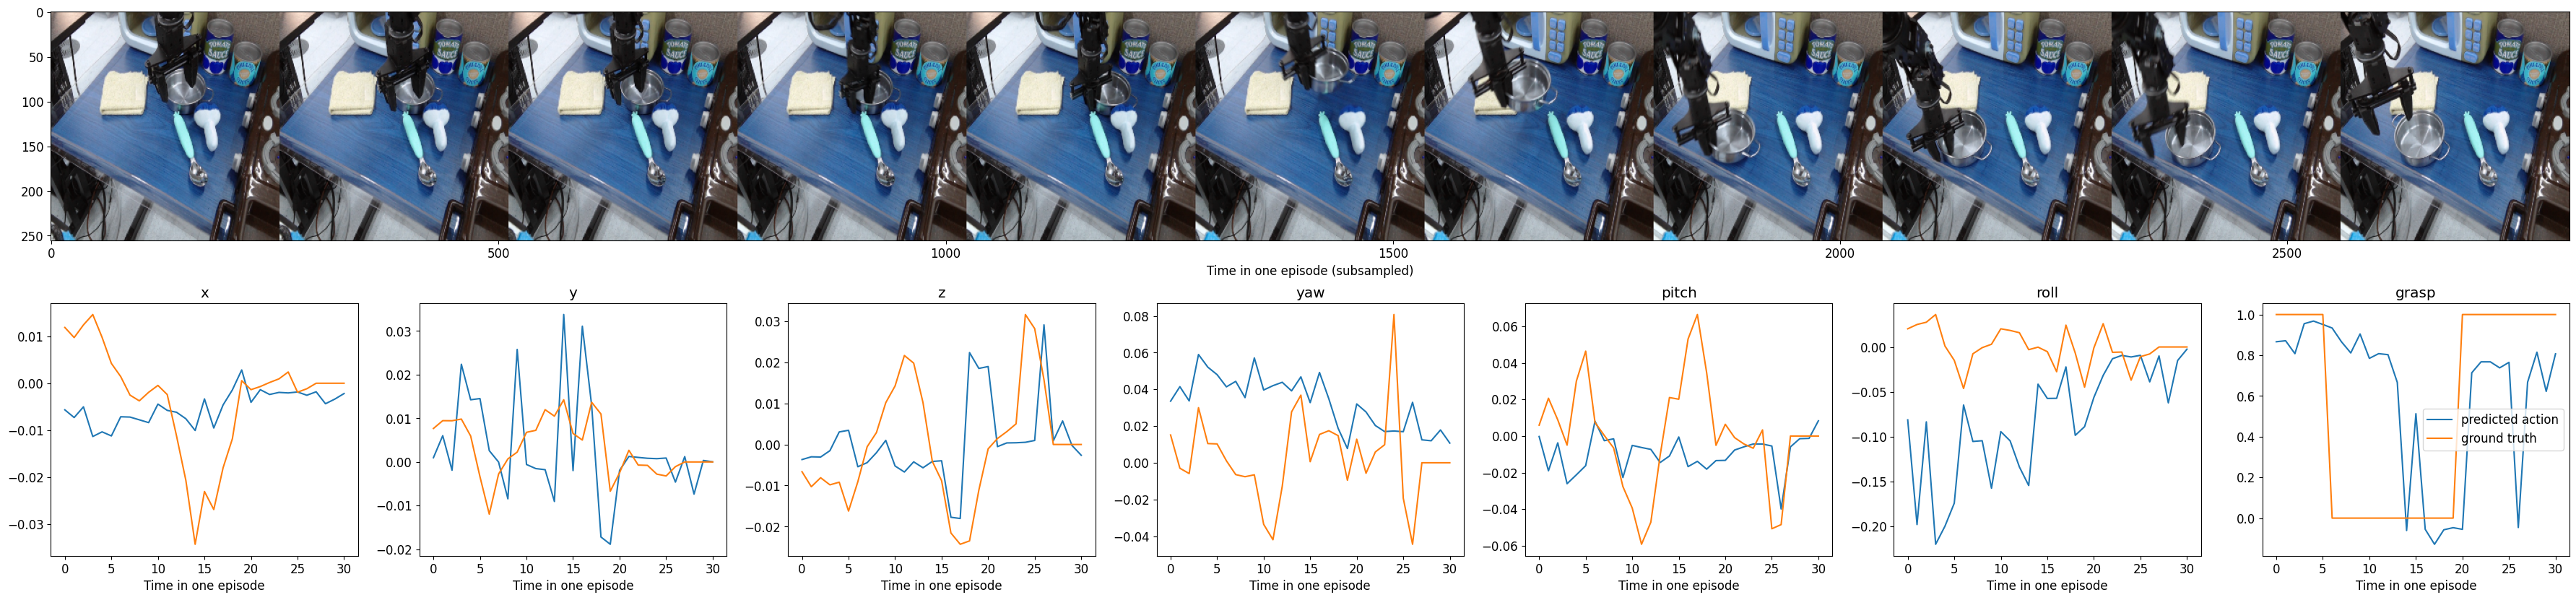

In [6]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()